# Thompson Sampling - Step 3:
Optimization with uncertain conversion rates. Focus on the situation in which the binary features cannot be observed and therefore data are aggregated. Design bandit algorithms (based on UCB and TS) to face the case in which the conversion rates are unknown. Develop the algorithms by Python and evaluate their performance when applied to your simulator.

In [1]:
import json

def arrays_mean(arrays, weights):
    tot_weights = sum(weights)
    if len(arrays) == 0:
        return []

    ret = arrays[0]
    for i in range(0, len(ret)):
        ret[i] = ret[i]*weights[0]

    for i in range(1, len(arrays)):
        for j in range(0, len(arrays[0])):
                ret[j] += arrays[i][j]*weights[i]

    for i in range(0, len(ret)):
        ret[i] = ret[i]/(len(arrays)*tot_weights)

    return ret

def matrices_mean(matrices, weights):
    tot_weights = sum(weights)
    if len(matrices) == 0:
        return []

    ret = matrices[0]
    for i in range(0, len(ret)):
        for j in range(0, len(ret[0])):
            ret[i][j] = ret[i][j]*weights[0]

    for i in range(1, len(matrices)):
        for j in range(0, len(matrices[0])):
            for k in range(0, len(matrices[0][0])):
                ret[j][k] += matrices[i][j][k]*weights[i]

    for i in range(0, len(ret)):
        for j in range(0, len(ret[0])):
            ret[i][j] = ret[i][j]/(len(matrices)*tot_weights)

    return ret

def load_mean_config(file_path):
    f = open(file_path)
    config = json.load(f)
    f.close()
    ucs = config["classes"]
    margins = config["margins"]
    optimal_config = config["optimalConfig"]
    productList = [Product(int(key), ucs[0]["secondary"][key]) for key in ucs[0]["secondary"]] #same for each class

    convRates = []
    click_prob = []
    lambda_p = 0
    alphas = []
    units_mean = []
    users_mean = []
    users_variance = []

    for uc in ucs:
        #medie
        convRates.append(uc["conversionRates"])
        click_prob.append(uc["clickProbability"])
        lambda_p += uc["lambda"]
        alphas.append(uc["alphas"])
        units_mean.append(uc["unitsShape"])
        users_mean.append(uc["usersMean"])
        users_variance.append(uc["usersVariance"])

    lambda_p = lambda_p/len(ucs)
    alphas = arrays_mean(alphas, users_mean)
    units_mean = arrays_mean(units_mean, users_mean)
    click_prob = matrices_mean(click_prob, users_mean)
    convRates = matrices_mean(convRates, users_mean)

    num_prices = len(convRates[0])
    num_prods = len(alphas)

    pulledArm = [0, 3, 0, 2, 0] # [3, 2, 0, 3, 2]
    configuration = {"productList": productList, "click_prob": click_prob, "lambda_p": lambda_p, "alphas": alphas, "units_mean": units_mean,
                     "num_prices": num_prices, "num_prods": num_prods, "optimal_config": optimal_config, "pulledArm": pulledArm,
                     "margins": margins, "convRates": convRates, "usersMean": users_mean, "usersVariance": users_variance}
    return configuration

Configuration file  0 :
Optimal arm found:
	 [2, 2, 1, 3, 2] 
Optimal theoretical arm:
	 [2, 2, 0, 2, 2]


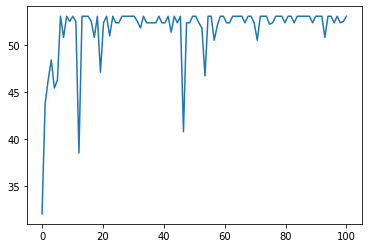

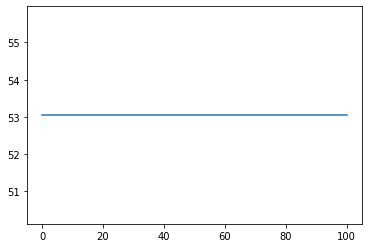

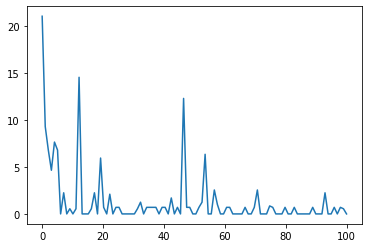

In [9]:
from Environment import Environment
from Learner.TS_CR import *
from Model.Product import *
import json
import matplotlib.pyplot as plt
from Model.Evaluator.GraphEvaluator import *

def total_margin_per_node(envReturn, marginsPerPrice, pulledArm):
    TotMargin = 0
    for e in envReturn["episodes"]:
        if e.bought:
            TotMargin += marginsPerPrice[e.product][pulledArm[e.product]] * e.units
    return TotMargin

files = ['./Configs/config1.json']
#files = ['./Configs/config1.json', './Configs/Config2.json']
env = []
tsLearners = []
config_margins = []
optimal_arms = []
conv_rates = []
prod_lists = []
click_probs = []
lambdas = []
alphas = []
units_means = []
n_experiments = 100
n_loops = 1

for i in range(0, len(files)):
    env.append(Environment(config_path=files[i]))
    config = load_mean_config(files[i])
    l = config["lambda_p"]
    tsLearners.append(TS_CR(margins=config["margins"], alphas=config["alphas"], secondary_prod=config["productList"],
                            click_prob=config["click_prob"], l=l))
    config_margins.append(config["margins"])
    optimal_arms.append(config["optimal_config"])
    conv_rates.append(config["convRates"])
    prod_lists.append(config["productList"])
    click_probs.append(config["click_prob"])
    lambdas.append(config['lambda_p'])
    alphas.append(config["alphas"])
    units_means.append(config["units_mean"])

tot_ts_learner_margins = []
tot_optimal_margins = []

for i in range(0, len(env)):
    ts_learner_margins = np.array([])
    optimal_margins = np.array([])
    for j in range(0, n_experiments):
        ts_single_margin = 0
        opt_single_margin = 0
        armMargins = []
        armConvRates = []

    # compute the margin for the TS
        pulledArm = tsLearners[i].pull_arm()
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

        env[i].setPriceLevels(pulledArm)
        for k in range(0, n_loops):
            ts_interactions = env[i].round()
            ts_single_margin += graphEval.computeMargin()
            #ts_single_margin += total_margin_per_node(ts_interactions, config_margins[i], pulledArm)
        ts_single_margin /= n_loops
        tsLearners[i].update(ts_interactions, pulledArm)

    # compute the margin for the optimal
        armConvRates = []
        armMargins = []
        pulledArm = optimal_arms[i]
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

        env[i].setPriceLevels(pulledArm)
        for k in range(0, n_loops):
            opt_interactions = env[i].round()
            opt_single_margin += graphEval.computeMargin()
            #opt_single_margin += total_margin_per_node(opt_interactions, config_margins[i], pulledArm)
        opt_single_margin /= n_loops

        #add the margins
        ts_learner_margins = np.append(ts_learner_margins, ts_single_margin)
        optimal_margins = np.append(optimal_margins, opt_single_margin)

    tot_ts_learner_margins.append(ts_learner_margins)
    tot_optimal_margins.append(optimal_margins)
    print("Configuration file ", i, ":\nOptimal arm found:\n\t", tsLearners[i].pull_arm(), "\nOptimal theoretical arm:\n\t", optimal_arms[i])


x = np.linspace(0, n_experiments, n_experiments)
fig1, ax1 = plt.subplots()
ax1.plot(x, tot_ts_learner_margins[0])
fig2, ax2 = plt.subplots()
ax2.plot(x, tot_optimal_margins[0])
fig3, ax3 = plt.subplots()
ax3.plot(x, tot_optimal_margins[0]-tot_ts_learner_margins[0])
plt.show()

In [50]:
from Learner.GreedyLearner import *
import json
from Model.Product import *
from Model.Evaluator.GraphEvaluator import GraphEvaluator

config = load_mean_config('./Configs/Config1.json')
greedyLearner = GreedyLearner(debug=True)

pulledArm = greedyLearner.pull_arm()
previousConfig = []
while pulledArm != previousConfig:
   armMargins = []
   armConvRates = []
   for k in range(0, len(pulledArm)):
       armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
       armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])

   # Initialization of GraphEvaluator object:
   graphEval = GraphEvaluator(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
               alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=False)

   # Price configuration evaluation and greedy Learner margin update:
   margin = graphEval.computeMargin()
   print("Configuration: {}, configurationMargin: {}".format(pulledArm, margin) )

   greedyLearner.update(margin)

   previousConfig = pulledArm
   pulledArm = greedyLearner.pull_arm()

print("Optimal configuration: {}\n Optimal configuration's margin: {}".format(greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin))

{'productList': [<Model.Product.Product object at 0x000002DD97F17190>, <Model.Product.Product object at 0x000002DD97F14760>, <Model.Product.Product object at 0x000002DD97F15E70>, <Model.Product.Product object at 0x000002DD97F159F0>, <Model.Product.Product object at 0x000002DD97F16FB0>], 'click_prob': [[0.0, 0.5, 0.6, 0.0, 0.0], [0.0, 0.0, 0.4, 0.0, 0.2], [0.0, 0.0, 0.0, 0.8, 0.7], [0.6, 0.0, 0.0, 0.0, 0.5], [0.0, 0.9, 0.0, 0.3, 0.0]], 'lambda_p': 0.7, 'alphas': [0.3, 0.25, 0.15, 0.15, 0.15], 'units_mean': [0.75, 1.25, 1.6, 2.1, 0.94], 'num_prices': 4, 'num_prods': 5, 'optimal_config': [2, 2, 0, 2, 2], 'pulledArm': [0, 3, 0, 2, 0], 'margins': [[1, 2, 10, 16], [10, 20, 35, 40], [12, 15, 18, 21], [3, 8, 15, 21], [8, 10, 17, 26]], 'convRates': [[0.7, 0.7, 0.4, 0.2], [0.9, 0.8, 0.6, 0.2], [0.9, 0.7, 0.5, 0.3], [0.8, 0.7, 0.4, 0.3], [0.9, 0.65, 0.45, 0.2]], 'usersMean': 100, 'usersVariance': 1}


KeyError: 'marginsPerPrice'